###**README**

---
####**INTRODUCTION TO SPH**
---

####_Smoothed Particle Hydrodynamics (SPH) is a numerical simulation technique used for modeling fluid dynamics and various physical phenomena. Unlike grid-based methods, SPH represents the fluid as a collection of particles, each possessing properties such as density, velocity, and pressure. The interaction between particles is determined by a smoothing kernel, enabling the simulation of complex fluid behaviors._

####_This SPH code is designed to provide a straightforward implementation of the SPH simulation method. Whether you are delving into fluid dynamics research or incorporating realistic fluid simulations into your project, this code offers a practical starting point._  
  
>  
>  
---
####**CODE OVERVIEW**
---

This Python code implements a basic application of the incompressible Navier-Stokes using Smoothed Particle Hydrodynamics (SPH).  
The code leverages Numba for Just-in-Time (JIT) compilation and supports multithreading.  
  
>**USAGE:**   
>>  

1.   Configure Numba settings in **NUMBA PARAMETERS**
2.   Set solver parameters in **SIM PARAMETERS**
3.   Set user-defined functions in **USER-DEFINED FUNCTIONS** (optional)
3.   Run the cells following the sequential order of **CODE SECTION**,   
     can  follow the simulation outputs in **SIMULATION CYCLE** cell
4.   Explore results in **RESULTS SECTION** at the end of simulation


>**DEPENDENCIES:**
>> os  
inspect  
re: 2.2.1  
csv: 1.0  
imageio: 2.31.6  
numpy: 1.23.5  
numba: 0.58.1  
matplotlib: 3.7.1  
IPython: 7.34.0  

---
####**REFERENCES**   
---

>**THEORY INTRODUCTION:**  
>>'Smoothed Particle Hydrodynamics'  
>>Peter J. Cossins  
>>https://arxiv.org/pdf/1007.1245.pdf

>**REFERENCE IMPLEMENTATION:**  
>>https://lucasschuermann.com/writing/implementing-sph-in-2d

>**BC THREATMENT and ADAPTIVE DT in SPH:**  
>>'How to Train Your Solver: Verification of Boundary Conditions for Smoothed Particle Hydrodynamics'  
Pawan Negia, Prabhu Ramachandrana  
https://arxiv.org/pdf/2208.10848.pdf#:~:text=In%20SPH%2C%20two%20types%20of,and%20influence%20the%20fluid%20particles.

>>'Boundary Threatment Techniques in Smoothed Particle Hydrodynamics: Implementation in fluid and Thermal Science and Results Analysis'   
>>Carlos Alberto Dutra Fraga Filho, Julio Tomás Aquije Chacaltana  
>>https://periodicos.unb.br/index.php/ripe/article/download/21270/19619/37408

>> 'Time Adaptive Approximate SPH'  
>> Prashant Goswami, Renato Pajarola
>> https://maverick.inria.fr/~Prashant.Goswami/Research/Papers/VRIPHYS11_TAASPH.pdf

>>'Boundary Handling and Adaptive Time-Stepping for PCISPH'
>> Markus Ihmsen, Nadir Akinci, Marc Gissler, Matthias Teschner  
>>https://cg.informatik.uni-freiburg.de/publications2010_VRIPHYS_boundaryHandling.pdf


---



### **CODE SECTION**

In [ ]:
# @title #####__IMPORTS__
%%capture
# ^_ Magic command to hide section outputs (for Colab env)

locals().clear()
globals().clear()

#-------------------------------------------------------------------------------
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# TERMINAL COMMANDS-------------------------------------------------------------
# '!' means 'to terminal' in Colab env

!rm -rf ./output/  # should be parametrized
!mkdir ./output
!cd ./ouput/

#-------------------------------------------------------------------------------

import os
import re
import csv  # using csv because pandas is problematic for NUMBA optimization
import imageio
import inspect
import numpy as np
from numba import jit, njit, float64, threading_layer, set_num_threads, config
from numba.experimental import jitclass
import matplotlib.pyplot as plt
from IPython.display import display, Image

import warnings
from numba import NumbaWarning
# Ignore all Numba warnings
warnings.filterwarnings("ignore", category=NumbaWarning)

#_______________________________________________________________________________
# CHECK PACKAGES VERSION:
#_______________________________________________________________________________
#import os
#packages = [
#    'os',
#    're',  # regex module
#    'csv',
#    'imageio',
#    'inspect',
#    'numpy',
#    'numba',
#    'matplotlib',
#    'IPython'
#]
#
#for package in packages:
#    try:
#        version = os.popen(f"pip show {package} | grep Version").read().strip().split(': ')[1]
#        print(f"{package}: {version}")
#    except Exception as e:
#        print(f"Error getting version for {package}: {e}")
#
#_______________________________________________________________________________
# THE FOLLOWING CODE WORKS PROPERLY WITH THESE PACKAGES VERSION:
#_______________________________________________________________________________
# re: 2.2.1
# csv: 1.0
# imageio: 2.31.6
# numpy: 1.23.5
# numba: 0.58.1
# matplotlib: 3.7.1
# IPython: 7.34.0
#_______________________________________________________________________________

In [ ]:
# @title #####__INITIALIZATION__


#-------------------------------------------------------------------------------
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# SOLVER DATA INIT--------------------------------------------------------------

particles = []
csv_data  = []
user_defined_functions = []

#-------------------------------------------------------------------------------
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# USER INTERFACE DECORATORS-----------------------------------------------------

# used to manage NUMBA optimization from user setting
def conditional_decorator(dec, condition):
    def decorator(func):
        if not condition:
            # Return the function unchanged, not decorated
            return func
        return dec(func)
    return decorator

# used to manage user-defined functions
def user_defined_function(func):
    user_defined_functions.append(func)
    return func



In [ ]:
# @title #####__NUMBA PARAMETERS__

USE_JIT = True                         # 'True' raccomanded, enable C compiling
config.THREADING_LAYER = "threadsafe"  # is OpenMP in Linux env
config.NUMBA_NUM_THREADS = 8           # set max thereads usable from numba


In [ ]:
# @title #####__SIM PARAMETERS__

#-------------------------------------------------------------------------------
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# SOLVER SETTINGS---------------------------------------------------------------

G = np.array([0.0, -9.807]) # external (gravitational) forces '-9.807'
REST_DENS = 300.0   # rest density
GAS_CONST = 2000.0  # const for equation of state
H = 16.0            # kernel radius
HSQ = H * H         # radius^2 for optimization
MASS = 2.5          # assume all particles have the same mass
VISC = 200.0        # viscosity constant
DT = 0.001          # integration timestep (Ignored if ADAPTIVE_DT = True)
SIM_TIME = 1.1      # simulation time in sec
INT_METHOD = 'Ex_Euler'  # integration method (Flags: 'RK4' = RK4, 'Ex_Euler' = Explicit Euler)
ADAPTIVE_DT = True # activate adaptive DT to keep CFL bounded
ALPHA = 0.4        # CFL threshold for ADAPTIVE_DT

SAVING_RATE = 20    # save picture and results every N steps
OUTPUT_DIR_PATH = './output/' # output file path

#-------------------------------------------------------------------------------
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# KERNEL INFO-------------------------------------------------------------------

# smoothing kernels defined in Müller and their gradients
# adapted to 2D per "SPH Based Shallow Water Simulation" by Solenthaler et al.
POLY6 = 4.0 / (np.pi * pow(H, 8.0))
SPIKY_GRAD = -10.0 / (np.pi * pow(H, 5.0))
VISC_LAP = 40.0 / (np.pi * pow(H, 5.0))

#-------------------------------------------------------------------------------
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# BC----------------------------------------------------------------------------

# TODO: inspect variables BC exploiting lambda functions properly
# UPDATE: seems work

BOUND_DAMPING = -0.5
# avalilable keys: 'v_normal', 'v_tangent', 'pressure', 'type': 'Wall'/'Open'
BOUNDARY_CONDITION_dict = {
        'North': {'v_normal': lambda p: (p.v[1] * BOUND_DAMPING), 'type': 'Wall'},
        'South': {'v_normal': lambda p: (p.v[1] * BOUND_DAMPING), 'type': 'Wall'},
        'East':  {'v_normal': lambda p: (p.v[0] * BOUND_DAMPING), 'type': 'Wall'},
        'West':  {'v_normal': lambda p: (p.v[0] * BOUND_DAMPING), 'type': 'Wall'}}

#-------------------------------------------------------------------------------
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# IC----------------------------------------------------------------------------

# TODO: initial condition works but needs further checks

VIEW_WIDTH = 1200
VIEW_HEIGHT = 900
EPS = H  # boundary tolerance

# Initial particle spawn
PARTICLES = 200 # CANT BE ZERO
# USING: 'None' means that partcles starts steady and act only under external forces eg. gravitational
# avalilable keys: 'initial_velocity', 'initial_force', 'initial_density', 'initial_pressure', 'shape': {'x_range': [], 'y_range': []}
PARTICLES_PROP_dict = {
       'initial_velocity': lambda: np.array([None, None]),
       'initial_force':    lambda: np.array([None, None]),
       'initial_density':  lambda: None,
       'initial_pressure': lambda: None,
       'shape':{'x_range': [VIEW_WIDTH / 4, VIEW_WIDTH / 3], 'y_range': [EPS, VIEW_HEIGHT - EPS * 2.0]}}
       #'shape':{'x_range': [EPS, 5 * EPS], 'y_range': [EPS, VIEW_HEIGHT - EPS]}}

# particle respawn
PARTICLES_RESPAWN = 150 # CAN BE ZERO (IF NOT ZERO DEFINE A RESPAWN POLICY in USER-DEFINED FUNCTIONS)
# avalilable keys: 'initial_velocity', 'initial_force', 'initial_density', 'initial_pressure', 'shape': {'x_range': [], 'y_range': []}
PARTICLES_RESPAWN_PROP_dict = {
       'initial_velocity': lambda: np.array([None, None]),
       'initial_force':    lambda: np.array([None, None]),
       'initial_density':  lambda: None,
       'initial_pressure': lambda: None,
       'shape':{'x_range': [(VIEW_WIDTH / 4) + 300, (VIEW_WIDTH / 3) + 300], 'y_range': [EPS, VIEW_HEIGHT - EPS * 2.0]}}
       #'shape':{'x_range': [VIEW_WIDTH / 4, VIEW_WIDTH / 3], 'y_range': [VIEW_HEIGHT - 10 * EPS, VIEW_HEIGHT - EPS]}}  #3* EPS, VIEW_WIDTH - 3 * EPS   VIEW_HEIGHT - 2 * EPS, VIEW_HEIGHT - EPS



In [ ]:
# @title #####__USER-DEFINED FUNCTIONS__ (optional)

# To be executed user-defined functions must be decorated with @user_defined_function
# the order of the functions is respected from decorator calling. Available inputs for
# user function are: 'DT', 'sim_time', 'step' and 'respect_cfl': (bool)
# all user-defined functions runs after each simulation step.

# custom particles respawn policy
@user_defined_function
def RESPAWN_CUSTOM_POLICY(step, sim_time, respect_cfl):
   add_particles(PARTICLES_RESPAWN_PROP_dict) if step == 4 and respect_cfl else None

### test decorator
##@user_defined_function
##def print_test(step):
   ##print('USER_DEFINED_FUNC TEST') if step == 20 else None

#-------------------------------------------------------------------------------

In [ ]:
# @title #####__FUNCTIONS DEFINITION__

#-------------------------------------------------------------------------------
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# PARTICLES INITIALIZATION & SPAWNER FUNCTIONS----------------------------------

spec = [
    ("x", float64[:]),
    ("v", float64[:]),
    ("f", float64[:]),
    ("rho", float64),
    ("p", float64),
]


@conditional_decorator(jitclass(spec=spec), condition=USE_JIT)
class Particle:
    def __init__(self, x, y, v, f, rho, p):
        self.x = np.array([x, y], dtype=np.float64)
        self.v = v
        self.f = f
        self.rho = rho
        self.p = p


# DONT USE @JIT TO THIS, IS A PYTHON INTERFACE TO HANDLE USER-INPUTS
def default_vector(value, default):
    return np.array(
        [
            value[i] if value is not None and value[i] is not None else default[i]
            for i in range(len(default))
        ],
        dtype=np.float64,
    )


# DONT USE @JIT TO THIS, IS A PYTHON INTERFACE TO HANDLE USER-INPUTS
def init_sph(properties=None, ignore_warnings=True):
    np.random.seed(89)
    print("initializing with", PARTICLES, "particles")

    # Check if properties contain shape information
    if "shape" in properties and isinstance(properties["shape"], dict):
        shape_properties = properties["shape"]
    else:
        None if ignore_warnings else print(
            "WARNING: init_sph() requires shape definition"
        )

    for y in np.arange(
        shape_properties["y_range"][0], shape_properties["y_range"][1], H
    ):
        for x in np.arange(
            shape_properties["x_range"][0], shape_properties["x_range"][1], H
        ):
            if len(particles) < PARTICLES:
                jitter = np.random.rand()

                # Extract properties from the input dictionary and apply defaults for vectors
                initial_velocity = (
                    properties["initial_velocity"]()
                    if "initial_velocity" in properties
                    else None
                )
                initial_force = (
                    properties["initial_force"]()
                    if "initial_force" in properties
                    else None
                )
                initial_density = (
                    properties["initial_density"]()
                    if "initial_density" in properties
                    else None
                )
                initial_pressure = (
                    properties["initial_pressure"]()
                    if "initial_pressure" in properties
                    else None
                )

                v = (
                    default_vector(initial_velocity, np.array([0.0, 0.0]))
                    if initial_velocity is not None
                    else np.array([0.0, 0.0])
                )
                f = (
                    default_vector(initial_force, np.array([0.0, 0.0]))
                    if initial_force is not None
                    else np.array([0.0, 0.0])
                )
                rho = (
                    default_vector(initial_density, np.array([0.0]))
                    if initial_density is not None
                    else np.array([0.0])
                )
                p = (
                    default_vector(initial_pressure, np.array([0.0]))
                    if initial_pressure is not None
                    else np.array([0.0])
                )

                particles.append(Particle(x + jitter, y, v, f, rho, p))


# DONT USE @JIT TO THIS, IS A PYTHON INTERFACE TO HANDLE USER-INPUTS
def add_particles(properties=None, ignore_warnings=True):
    if PARTICLES_RESPAWN > 0:
        np.random.seed(89)

        if "shape" in properties and isinstance(properties["shape"], dict):
            shape_properties = properties["shape"]
        else:
            print(
                "WARNING: add_particle() require shape definition"
            ) if ignore_warnings else None

        pre_spawning_particles = len(particles)
        counting_particles = len(particles)

        for y in np.arange(
            shape_properties["y_range"][0], shape_properties["y_range"][1], H
        ):
            for x in np.arange(
                shape_properties["x_range"][0], shape_properties["x_range"][1], H
            ):
                if counting_particles < (pre_spawning_particles + PARTICLES_RESPAWN):
                    jitter = np.random.rand()

                    # Extract properties from the input dictionary and apply defaults for vectors
                    initial_velocity = (
                        properties["initial_velocity"]()
                        if "initial_velocity" in properties
                        else None
                    )
                    initial_force = (
                        properties["initial_force"]()
                        if "initial_force" in properties
                        else None
                    )
                    initial_density = (
                        properties["initial_density"]()
                        if "initial_density" in properties
                        else None
                    )
                    initial_pressure = (
                        properties["initial_pressure"]()
                        if "initial_pressure" in properties
                        else None
                    )

                    v = (
                        default_vector(initial_velocity, np.array([0.0, 0.0]))
                        if initial_velocity is not None
                        else np.array([0.0, 0.0])
                    )
                    f = (
                        default_vector(initial_force, np.array([0.0, 0.0]))
                        if initial_force is not None
                        else np.array([0.0, 0.0])
                    )
                    rho = (
                        default_vector(initial_density, np.array([0.0]))
                        if initial_density is not None
                        else np.array([0.0])
                    )
                    p = (
                        default_vector(initial_pressure, np.array([0.0]))
                        if initial_pressure is not None
                        else np.array([0.0])
                    )

                    particles.append(Particle(x + jitter, y, v, f, rho, p))
                    counting_particles += 1
        print(PARTICLES_RESPAWN, "PARTICLES ADDED")

#-------------------------------------------------------------------------------
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# CORE COMPUTATION FUNCTIONS----------------------------------------------------

@conditional_decorator(jit(fastmath=True, forceobj=True), condition=USE_JIT)
def apply_boundary_conditions(p, side, boundary_conditions):

    global particles

    if side == "North" and p.x[1] + EPS > VIEW_HEIGHT:
        if boundary_conditions.get("type") == "Wall":
            p.x[1] = VIEW_HEIGHT - EPS
            p.v[1] = (
                boundary_conditions.get("v_normal")(p)
                if "v_normal" in boundary_conditions
                else p.v[1]
            )
            p.v[0] = (
                boundary_conditions.get("v_tangent")(p)
                if "v_tangent" in boundary_conditions
                else p.v[0]
            )
            p.p = (
                boundary_conditions.get("pressure")(p)
                if "pressure" in boundary_conditions
                else p.p
            )
        elif boundary_conditions.get("type") == "Open":
            particles.remove(p)  # Remove particle for Open boundary

    elif side == "South" and p.x[1] - EPS < 0.0:
        if boundary_conditions.get("type") == "Wall":
            p.x[1] = EPS
            p.v[1] = (
                boundary_conditions.get("v_normal")(p)
                if "v_normal" in boundary_conditions
                else p.v[1]
            )
            p.v[0] = (
                boundary_conditions.get("v_tangent")(p)
                if "v_tangent" in boundary_conditions
                else p.v[0]
            )
            p.p = (
                boundary_conditions.get("pressure")(p)
                if "pressure" in boundary_conditions
                else p.p
            )
        elif boundary_conditions.get("type") == "Open":
            particles.remove(p)

    elif side == "East" and p.x[0] + EPS > VIEW_WIDTH:
        if boundary_conditions.get("type") == "Wall":
            p.x[0] = VIEW_WIDTH - EPS
            p.v[0] = (
                boundary_conditions.get("v_normal")(p)
                if "v_normal" in boundary_conditions
                else p.v[0]
            )
            p.v[1] = (
                boundary_conditions.get("v_tangent")(p)
                if "v_tangent" in boundary_conditions
                else p.v[1]
            )
            p.p = (
                boundary_conditions.get("pressure")(p)
                if "pressure" in boundary_conditions
                else p.p
            )
        elif boundary_conditions.get("type") == "Open":
            particles.remove(p)

    elif side == "West" and p.x[0] - EPS < 0.0:
        if boundary_conditions.get("type") == "Wall":
            p.x[0] = EPS
            p.v[0] = (
                boundary_conditions.get("v_normal")(p)
                if "v_normal" in boundary_conditions
                else p.v[0]
            )
            p.v[1] = (
                boundary_conditions.get("v_tangent")(p)
                if "v_tangent" in boundary_conditions
                else p.v[1]
            )
            p.p = (
                boundary_conditions.get("pressure")(p)
                if "pressure" in boundary_conditions
                else p.p
            )
        elif boundary_conditions.get("type") == "Open":
            particles.remove(p)


@conditional_decorator(jit(fastmath=True, forceobj=True, looplift=True, parallel=True), condition=USE_JIT)
def calculate_cfl_time_step():
    tau = 0.98  # tolerance to avoid to much iteration
    # V-- computed as proposed in 'Time Adaptive Approximate SPH'
    max_velocity = np.max(np.array([np.linalg.norm(p.v) for p in particles])) + np.sqrt(
        np.max(np.array([np.linalg.norm(p.f) for p in particles])) * H
    )
    cfl_time_step = round(tau * ALPHA * (H / max_velocity), 6)
    return cfl_time_step, max_velocity


@conditional_decorator(njit(fastmath=True, inline="always"), condition=USE_JIT)
def euler_integration(p):
    p.v += DT * p.f / p.rho
    p.x += DT * p.v


@conditional_decorator(njit(fastmath=True, inline="always"), condition=USE_JIT)
def runge_kutta_4_integration(p):  # TODO: <--- generate wrong results !!!!
    k1_v = DT * (p.f / p.rho)
    k1_x = DT * p.v
    k2_v = DT * ((p.f / p.rho) + k1_v / 2)
    k2_x = DT * (p.v + k1_x / 2)
    k3_v = DT * ((p.f / p.rho) + k2_v / 2)
    k3_x = DT * (p.v + k2_x / 2)
    k4_v = DT * ((p.f / p.rho) + k3_v)
    k4_x = DT * (p.v + k3_x)

    p.v += (k1_v + 2 * k2_v + 2 * k3_v + k4_v) / 6
    p.x += (k1_x + 2 * k2_x + 2 * k3_x + k4_x) / 6


@conditional_decorator(jit(inline="always"), condition=USE_JIT)
def integrate(method="Ex_Euler"):

    global BOUNDARY_CONDITION_dict
    global particles

    north_bc = BOUNDARY_CONDITION_dict.get("North", {})
    south_bc = BOUNDARY_CONDITION_dict.get("South", {})
    east_bc = BOUNDARY_CONDITION_dict.get("East", {})
    west_bc = BOUNDARY_CONDITION_dict.get("West", {})

    for p in particles:
        if method == "Ex_Euler":
            euler_integration(p)

        elif method == "RK4":
            runge_kutta_4_integration(p)

        apply_boundary_conditions(p, "North", north_bc)
        apply_boundary_conditions(p, "South", south_bc)
        apply_boundary_conditions(p, "East", east_bc)
        apply_boundary_conditions(p, "West", west_bc)


@conditional_decorator(njit(fastmath=True), condition=USE_JIT)
def compute_density_pressure(particles):
    # print('computing pressure') # debug check
    for pi in particles:
        pi.rho = 0.0
        for pj in particles:
            rij = pj.x - pi.x
            r2 = np.sum(rij**2)  # computing distance^2 to avoid computing sqrt, Pag 3 Sect 3.5 Müller et al / Particle-Based Fluid Simulation for Interactive Applications
            # v- is defined as H*H
            if r2 < HSQ:
                pi.rho += (MASS * POLY6 * pow(HSQ - r2, 3.0))  # kernel application for computing rho
        pi.p = GAS_CONST * (pi.rho - REST_DENS)


@conditional_decorator(njit(fastmath=True), condition=USE_JIT)
def compute_forces(particles):
    # print('computing forces') # debug check
    for pi in particles:
        fpress = np.array([0.0, 0.0])
        fvisc = np.array([0.0, 0.0])
        for pj in particles:
            if np.array_equal(pi.x, pj.x):  # Answer to: is pi.x == pj.x
                continue

            rij = pj.x - pi.x
            r = np.linalg.norm(rij)

            if r < H:
                # Forces from Müller et al / Particle-Based Fluid Simulation for Interactive Applications
                fpress += (-rij / r * MASS * (pi.p + pj.p) / (2.0 * pj.rho) * SPIKY_GRAD * pow(H - r, 3.0))
                fvisc += VISC * MASS * (pj.v - pi.v) / pj.rho * VISC_LAP * (H - r)
        fgrav = G * MASS / pi.rho
        pi.f = fpress + fvisc + fgrav


@conditional_decorator(jit(forceobj=True, inline="always", parallel=True), condition=USE_JIT)
def update():
    compute_density_pressure(particles)
    compute_forces(particles)
    integrate(method=INT_METHOD)

#-------------------------------------------------------------------------------
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# BUFFER-KEEPING FUNCTIONS------------------------------------------------------

@conditional_decorator(jit(forceobj=True, looplift=True), condition=USE_JIT)
def write_buffer():
    particle_array = np.array(
        [Particle(p.x[0], p.x[1], p.v, p.f, p.rho, p.p) for p in particles]
    )
    return particle_array


# Function to restore the simulation state from a buffer snapshot
@conditional_decorator(jit(forceobj=True, looplift=True), condition=USE_JIT)
def restore_buffer(buffer):
    return [Particle(s.x[0], s.x[1], s.v, s.f, s.rho, s.p) for s in buffer]

#-------------------------------------------------------------------------------
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# MAIN SIM LOOP-----------------------------------------------------------------

def simulate():
    init_sph(PARTICLES_PROP_dict)
    global DT
    global particles
    step = 0
    sim_time = 0.0
    print(
        f"SIMULATION STARTED, Simulation lenght [s]: {round(SIM_TIME, 4)}", end="\n\n"
    )
    if USE_JIT:
      print("___________________________________________________________________")
      print("Just-in-Time Compiling (NumbaJIT) running", end="\n\n")
      print("Threading layer chosen: %s" % config.THREADING_LAYER)
      print("Maximum threads usable: %s" % config.NUMBA_NUM_THREADS)
      print("___________________________________________________________________")

    while sim_time <= SIM_TIME:
        # print('_____________________STEP:', step) # debug check

        buffer = write_buffer()
        update()
        cfl_actual, max_velocity = compute_cfl()
        respect_cfl = True

        if ADAPTIVE_DT == True:  # Ex-Post DT correction
            DT = 10**-7 if step == 0 else DT
            cfl_target = ALPHA

            if cfl_actual > cfl_target:
                step -= 1
                sim_time -= DT
                print(
                    "Step Numb:",
                    step + 1,
                    ">>> CFL condition violated with DT:",
                    round(DT, 6),
                    "--> Reiterate with DT:",
                    round(DT / 2, 6),
                )
                particles = restore_buffer(buffer)
                DT = DT / 2
                respect_cfl = False
            else:
                previous_DT = DT
                (
                    DT,
                    _,
                ) = calculate_cfl_time_step()

        print(
            "Step Numb:",
            step,
            " | Sim. time [s]:",
            round(sim_time, 6),
            " | CFL:",
            round(cfl_actual, 4),
            " | Max corr. velocity:",
            round(max_velocity, 4),
            end="\n\n",
        ) if respect_cfl else None
        save_to_csv(step, sim_time, particles) if respect_cfl else None
        # -----------------------------------------------------------------------
        # USER-DEFINED FUNCTIONS RUNS HERE:

        common_args = {
            "DT": previous_DT,
            "sim_time": sim_time,
            "step": step,
            "respect_cfl": respect_cfl
        }

        for user_func in user_defined_functions:
            args = inspect.signature(user_func).parameters
            user_func_args = {arg: common_args[arg] for arg in args}
            user_func_result = user_func(**user_func_args)

        # -----------------------------------------------------------------------
        step += 1
        sim_time += DT

#-------------------------------------------------------------------------------
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# AUXILIARY FUNCTIONS-----------------------------------------------------------

@conditional_decorator(jit(fastmath=True, forceobj=True, looplift=True, parallel=True), condition=USE_JIT)
def compute_cfl():
    max_velocity = np.max(np.array([np.linalg.norm(p.v) for p in particles])) + np.sqrt(
        np.max(np.array([np.linalg.norm(p.f) for p in particles])) * H
    )
    cfl = max_velocity * DT / H  # is H the correct term for space resolution?
    return cfl, max_velocity


@conditional_decorator(jit(forceobj=True, looplift=True, parallel=True), condition=USE_JIT)
def plot_positions(step_title, sim_time_title, positions, show=False, save=True):
    plt.figure()
    title = str(
        "Step:" + str(step_title) + ", Sim Time:" + str(round(sim_time_title, 4)) + "s"
    )
    plt.title(title)
    for x, y in positions:
        plt.scatter(x, y, color="blue", marker="o")
    plt.xlim(0, VIEW_WIDTH)
    plt.ylim(0, VIEW_HEIGHT)
    plt.xlabel("X")
    plt.ylabel("Y")
    if show:
        plt.show()
    if save:
        plt.savefig(
            OUTPUT_DIR_PATH + "Step_" + str(step_title) + ".png", format="png", dpi=300
        )
        plt.close()


def save_to_csv(step, sim_time, particles):
    if step % (SAVING_RATE) == 0:
        data = [(p.x[0], p.x[1], p.v[0], p.v[1], p.rho, p.p) for p in particles]
        positions = [(p.x[0], p.x[1]) for p in particles]
        plot_positions(step, sim_time, positions)
        csv_data.append(data)
        print(f"SAVE --> Step Numb: {step}, Results Written to CSV", end="\n\n")
  # TODO V-- Find a way to replace 'with' with a sintatx NUMBA compliant
        with open(OUTPUT_DIR_PATH + "simulation_data.csv", "a", newline="") as csvfile:
            csvwriter = csv.writer(csvfile)
            if step == 0:
                csvwriter.writerow(
                    [
                        "Step",
                        "Particle",
                        "X",
                        "Y",
                        "Velocity_X",
                        "Velocity_Y",
                        "Density",
                        "Pressure",
                    ]
                )
            for i, row in enumerate(data):
                csvwriter.writerow([step, i] + list(row))


#-------------------------------------------------------------------------------

In [ ]:
# @title #####__SIMULATION CYCLE__

if True:  # <-- for non-Colab env use: if __name__ == "__main__":
    simulate()


Output streaming troncato alle ultime 5000 righe.

Step Numb: 278  | Sim. time [s]: 0.134302  | CFL: 0.3709  | Max corr. velocity: 12679.9541

Step Numb: 279 >>> CFL condition violated with DT: 0.000495 --> Reiterate with DT: 0.000248
Step Numb: 279  | Sim. time [s]: 0.13455  | CFL: 0.2059  | Max corr. velocity: 13312.4079

Step Numb: 280  | Sim. time [s]: 0.135021  | CFL: 0.3771  | Max corr. velocity: 12809.366

SAVE --> Step Numb: 280, Results Written to CSV

Step Numb: 281 >>> CFL condition violated with DT: 0.00049 --> Reiterate with DT: 0.000245
Step Numb: 281  | Sim. time [s]: 0.135266  | CFL: 0.2001  | Max corr. velocity: 13068.8522

Step Numb: 282  | Sim. time [s]: 0.135746  | CFL: 0.387  | Max corr. velocity: 12899.9248

Step Numb: 283 >>> CFL condition violated with DT: 0.000486 --> Reiterate with DT: 0.000243
Step Numb: 283  | Sim. time [s]: 0.135989  | CFL: 0.1984  | Max corr. velocity: 13060.4635

Step Numb: 284  | Sim. time [s]: 0.136469  | CFL: 0.3887  | Max corr. veloci



---



### **RESULTS SECTION**

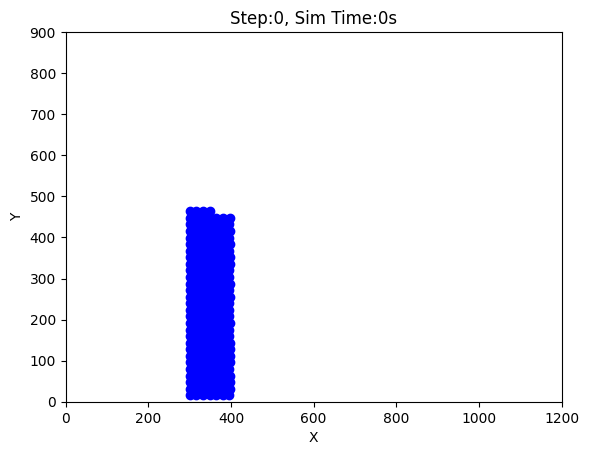

In [ ]:
# @title #####__STARTING CONDITION__
def read_csv_and_extract_initial_positions():
    global csv_data

    # Read the CSV file
    with open(OUTPUT_DIR_PATH+'simulation_data.csv', 'r') as csvfile:
        csvreader = csv.DictReader(csvfile)
        initial_positions = [(float(row['X']), float(row['Y'])) for row in csvreader if row['Step'] == '0']

    return initial_positions

csv_data = []
INIT_POS = read_csv_and_extract_initial_positions()
plot_positions(0, 0, INIT_POS, show=True, save=False)

GIF created: ./output/Output_Animation.gif


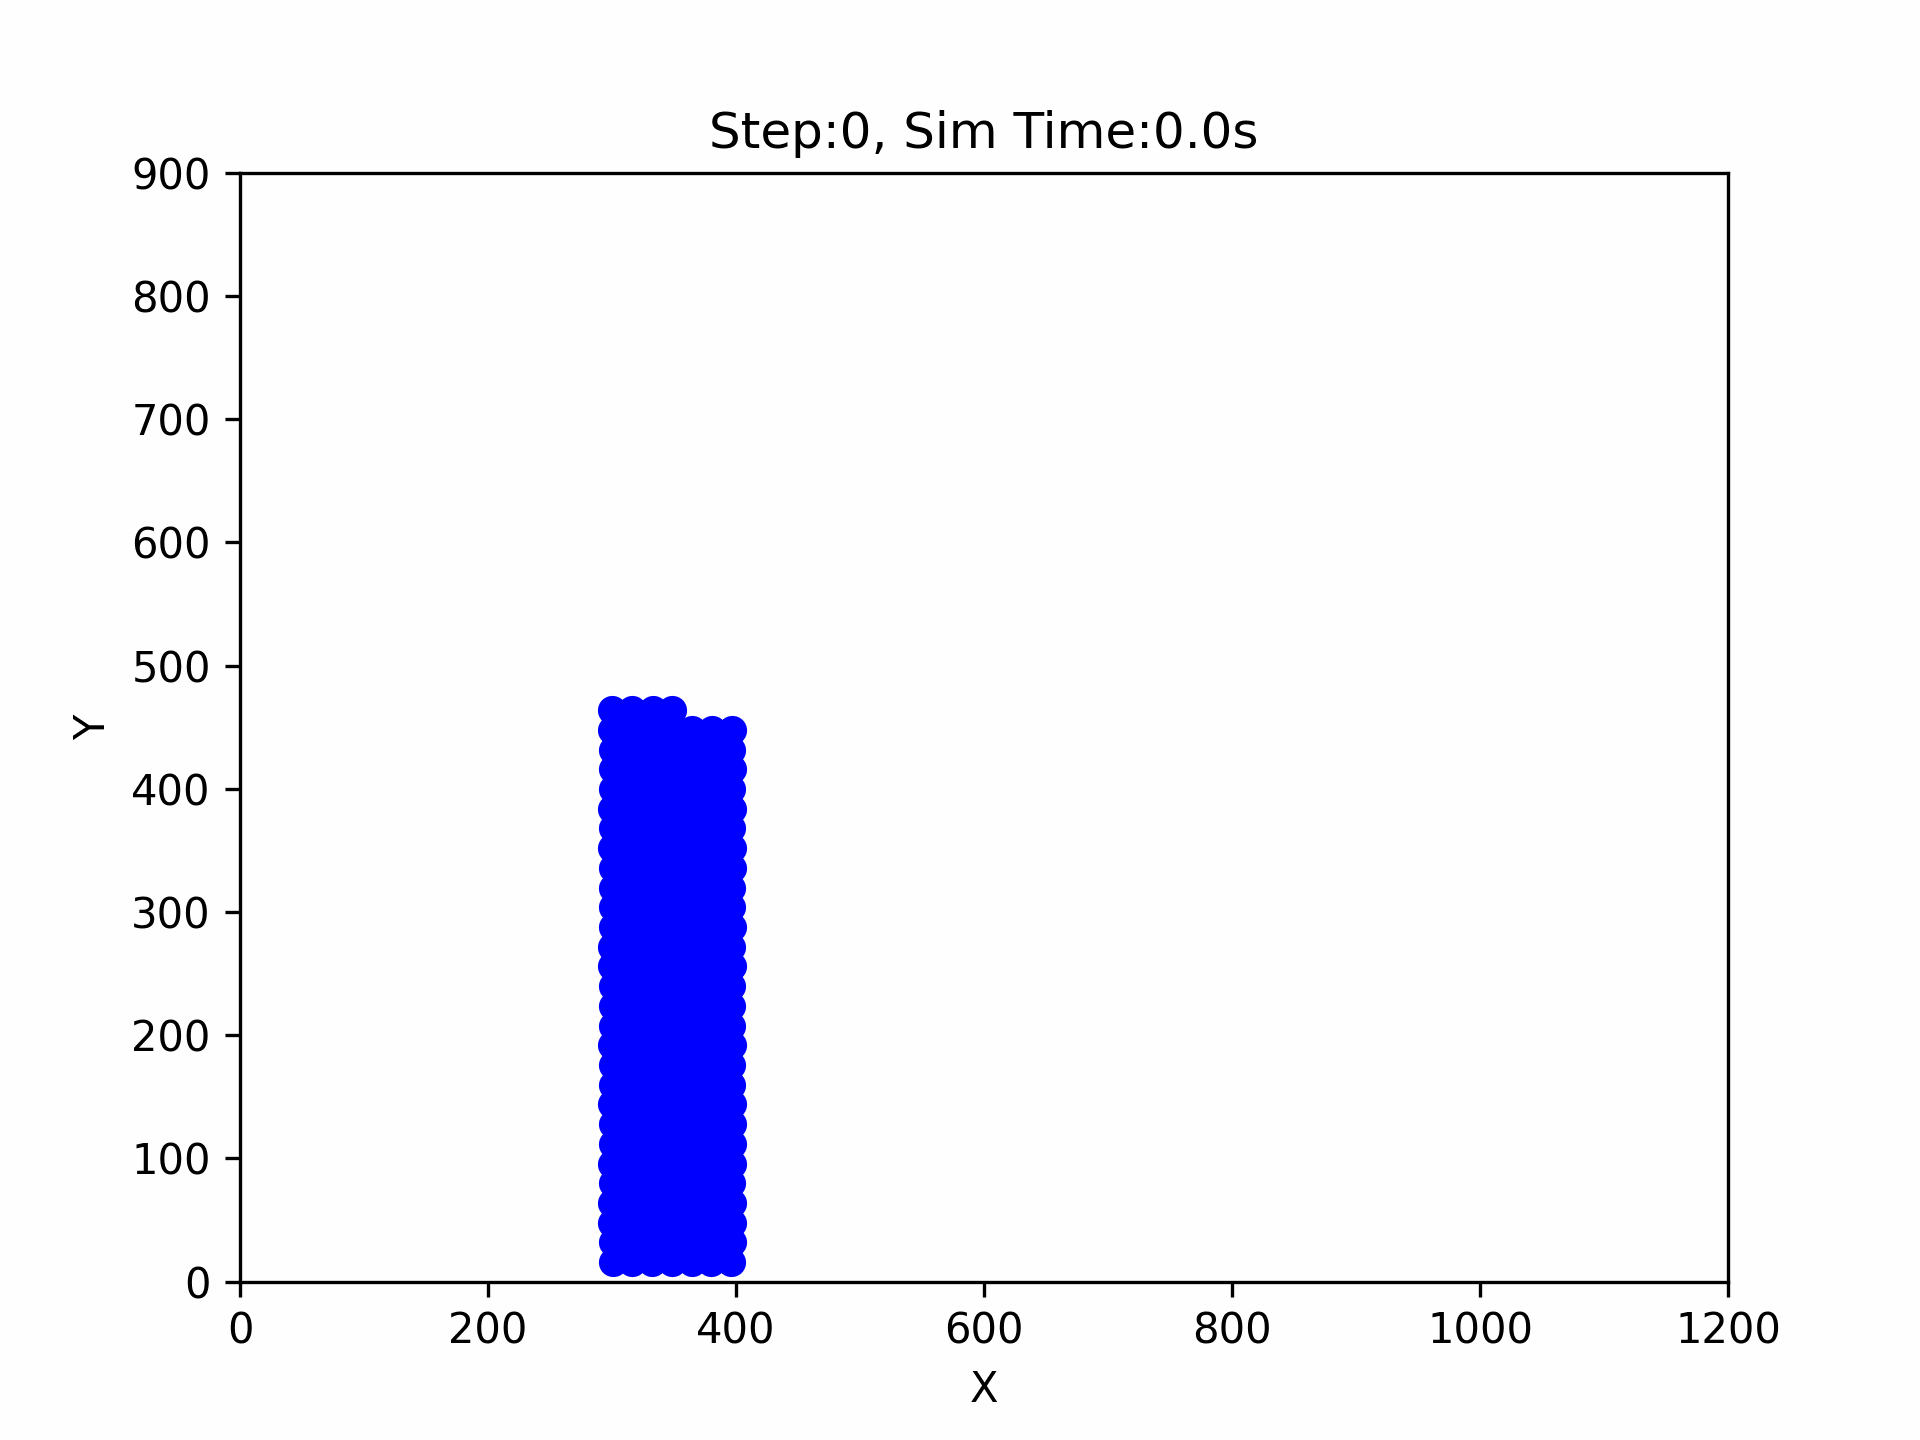

In [ ]:
# @title #####__SIMULATION OUTPUT__
# # Directory containing PNG images
image_folder = OUTPUT_DIR_PATH

# Output GIF file
output_gif = OUTPUT_DIR_PATH+'Output_Animation.gif'

# List the PNG files in the directory
png_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')], key=lambda x: int(re.search(r'\d+', x).group()))
# this because lexicographical sorting of strings put 100 before 2, so '\d+' search digit in the file name to sort numerically

# Create a list to store the images
images = []

# Read each PNG file and append to the list
for png_file in png_files:
    image_path = os.path.join(image_folder, png_file)
    images.append(imageio.imread(image_path))

# Save the images as a GIF
imageio.mimsave(output_gif, images, duration=0.5, loop=0)  # Adjust the duration as needed,  loop=0 means infinity loop

print(f'GIF created: {output_gif}')
display(Image(filename=output_gif))



---
__LAST REVIEW:__ *DD/MM/YYYY*  
__NOTES:__  




### **DEV SECTION & NOTES**


```
#_______________________________________________________________________________
## NOTES:
#_______________________________________________________________________________

- Check 'TODO' comments in the code/parmeters settings
- IMPLEMENT (from Muller Paper):
  "5. Implementation
   Since the smoothing kernels used in SPH have finite support
   h, a common way to reduce the computational complexity is
   to use a grid of cells of size h. Then potentially interacting
   partners of a particle i only need to be searched in i’s own
   cell and all the neighboring cells. This technique reduces the
   time complexity of the force computation step from O(n2)
   to O(nm), m being the average number of particles per grid
   cell.
   With a simple additional trick we were able to speed
   up the simulation by an additional factor of 10. Instead of
   storing references to particles in the grid, we store copies
   of the particle objects in the grid cells (doubling memory
   consumption). The reason for the speed up is the proximity in
   memory of the information needed for interpolation which
   dramatically increases the cash hit rate.
   Further speedup might be possible through even better clustering
   using Hilbert space filling curves11. The data structure for fast
   neighbor searches is also used for surface tracking and rendering."

- IMPLEMENT: different particles density

#_______________________________________________________________________________
KNOWN ISSUES:
#_______________________________________________________________________________
  
- IC setting may lead to strange behaviours
- Using few particles lead to strange behaviours (eg: unaxpected splashes)



```



In [ ]:
# @title #####__[DEV SECTION_0]__

1/0 # <-- TO FORCE INTERRUPTION

#NOTES


"""
def save_to_csv(step, sim_time, particles):
    if step % (SAVING_RATE) == 0:
        data = [(p.x[0], p.x[1], p.v[0], p.v[1], p.rho, p.p) for p in particles]
        positions = [(p.x[0], p.x[1]) for p in particles]
        plot_positions(step, sim_time, positions)
        csv_data.append(data)
        print(f"SAVE --> Step Numb: {step}, Results Written to CSV", end="\n\n")
  # TODO V-- Find a way to replace 'with' with a sintatx NUMBA compliant
        with open(OUTPUT_DIR_PATH + "simulation_data.csv", "a", newline="") as csvfile:
            csvwriter = csv.writer(csvfile)
            if step == 0:
                csvwriter.writerow(
                    [
                        "Step",
                        "Particle",
                        "X",
                        "Y",
                        "Velocity_X",
                        "Velocity_Y",
                        "Density",
                        "Pressure",
                    ]
                )
            for i, row in enumerate(data):
                csvwriter.writerow([step, i] + list(row))
"""




"""
@jitclass(spec=spec)
class Particle:
    def __init__(self, x, y, v=None, f=None, rho=None, p=None):

        self.x = np.array([x, y], dtype=np.float64)

        default_v = np.array([0.0, 0.0], dtype=np.float64)
        self.v = default_v if v is None else np.array([v[0] if v[0] is not None else default_v[0],
                                                       v[1] if v[1] is not None else default_v[1]], dtype=np.float64)
        default_f = np.array([0.0, 0.0], dtype=np.float64)
        self.f = default_f if f is None else np.array([f[0] if f[0] is not None else default_f[0],
                                                       f[1] if f[1] is not None else default_f[1]], dtype=np.float64)
        self.rho = rho if rho is not None else 0.0
        self.p = p if p is not None else 0.0
"""

"""
# set init shape
def init_sph(properties=None, ignore_warnings=True):
    np.random.seed(89)
    # placing this section here all particles shares same initialization
    v = properties['initial_velocity']() if 'initial_velocity' in properties else None
    f = properties['initial_force']() if 'initial_force' in properties else None
    rho = properties['initial_density']() if 'initial_density' in properties else None
    p = properties['initial_pressure']() if 'initial_pressure' in properties else None
    print("initializing with", PARTICLES, "particles")

    # Check if properties contain shape information
    if 'shape' in properties and isinstance(properties['shape'], dict):
        shape_properties = properties['shape']
    else:
        None if ignore_warnings else print("WARNING: init_sph() require shape definition")

    for y in np.arange(shape_properties['y_range'][0], shape_properties['y_range'][1], H):
        for x in np.arange(shape_properties['x_range'][0], shape_properties['x_range'][1], H):
            if len(particles) < PARTICLES:
                jitter = np.random.rand()
                particles.append(Particle(x + jitter, y, v=v, f=f, rho=rho, p=p))

def add_particles(properties=None, ignore_warnings=True):
    if PARTICLES_RESPAWN > 0:
        np.random.seed(89)
        v = properties['initial_velocity']() if 'initial_velocity' in properties else None
        f = properties['initial_force']() if 'initial_force' in properties else None
        rho = properties['initial_density']() if 'initial_density' in properties else None
        p = properties['initial_pressure']() if 'initial_pressure' in properties else None

        if 'shape' in properties and isinstance(properties['shape'], dict):
            shape_properties = properties['shape']
        else:
            print("WARNING: add_particle() require shape definition") if ignore_warnings else None

        pre_spawning_particles = len(particles)
        counting_particles = len(particles)

        for y in np.arange(shape_properties['y_range'][0], shape_properties['y_range'][1], H):
            for x in np.arange(shape_properties['x_range'][0], shape_properties['x_range'][1], H):
               if counting_particles < (pre_spawning_particles + PARTICLES_RESPAWN):
                  jitter = np.random.rand()
                  particles.append(Particle(x + jitter, y, v=v, f=f, rho=rho, p=p))
                  counting_particles += 1
        print(PARTICLES_RESPAWN, 'PARTICLES ADDED')

"""
"""
    # Restore additional properties (velocity, force, density, pressure)
    for restored_particle, original_particle in zip(particles, buffer):
        restored_particle.v = np.array([original_particle.v[0], original_particle.v[1]])
        restored_particle.f = np.array([original_particle.f[0], original_particle.f[1]])
        restored_particle.rho = original_particle.rho
        restored_particle.p = original_particle.p
"""


# TASK 1
# ADD NACA -AIRFOIL FEATURES ...in dev__________________________________________

# NACA 2412 airfoil parameters, FROM USER
NACA_MAX_CAMBER = 2  # First digit
NACA_CAMBER_LOCATION = 4  # Second digit
NACA_THICKNESS = 12  # Last two digits

# Function to calculate NACA airfoil coordinates     # https://en.wikipedia.org/wiki/NACA_airfoil
def naca_airfoil_coordinates(x, chord, max_camber, camber_location, thickness):
    x = x / chord
    yc = 5 * thickness * (0.2969 * np.sqrt(x) - 0.1260 * x - 0.3516 * x**2 + 0.2843 * x**3 - 0.1036 * x**4)

    if x < camber_location:
        yt = max_camber / 100 * (x / camber_location**2) * (2 * camber_location - x)
    else:
        yt = max_camber / 100 * ((chord - x) / (1 - camber_location)**2) * (1 + x - 2 * camber_location)

    return yc, yt

# Generate NACA airfoil coordinates
def generate_naca_airfoil(chord, num_points=100):
    x_values = np.linspace(0, chord, num_points)
    upper_surface = np.zeros_like(x_values)
    lower_surface = np.zeros_like(x_values)

    for i, x in enumerate(x_values):
        yc, yt = naca_airfoil_coordinates(x, chord, NACA_MAX_CAMBER, NACA_CAMBER_LOCATION / 10, NACA_THICKNESS)
        upper_surface[i] = yc + yt
        lower_surface[i] = yc - yt

    return x_values, upper_surface, lower_surface

def is_particle_inside_naca_airfoil(particle):
    # Check if the particle is below the upper surface and above the lower surface of the NACA airfoil
    x, y = particle.x[0], particle.x[1]
    _, upper_surface, lower_surface = generate_naca_airfoil(1.0)  # Assuming a chord length of 1.0
    return lower_surface[np.searchsorted(upper_surface, x)] <= y <= upper_surface[np.searchsorted(lower_surface, x)]

def handle_naca_airfoil_interaction(particle):
    # Handle the interaction with the NACA airfoil
    particle.v = np.zeros_like(particle.v)

def apply_boundary_conditions(p, side, boundary_conditions):
    global particles
    #...
    # same code of running version
    # Check if the particle is close to the NACA airfoil
    if is_particle_inside_naca_airfoil(p):
        handle_naca_airfoil_interaction(p)
        return

def plot_positions(step_title, positions, show=False, save=True):
    plt.figure()
    title = str('Step:'+ str(step_title)+', Sim Time:'+ str(round(step_title*DT, 4))+'s')
    plt.title(title)

    # Plot NACA airfoil shape
    x_airfoil, upper_surface, lower_surface = generate_naca_airfoil(1.0)
    plt.plot(x_airfoil, upper_surface, color='black', linestyle='--', label='NACA Airfoil')
    plt.plot(x_airfoil, lower_surface, color='black', linestyle='--')

    for x, y in positions:
        plt.scatter(x, y, color='blue', marker='o')

    plt.xlim(0, VIEW_WIDTH)
    plt.ylim(0, VIEW_HEIGHT)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

    if show:
        plt.show()

    if save:
        plt.savefig(OUTPUT_DIR_PATH + 'Step_' + str(step_title) + '.png', format='png', dpi=300)
        plt.close()


# TASK 2
#TO EVALUATE____________________________________________________________________
! pip install pathos
from pathos.multiprocessing import Pool
import dill

In [ ]:
# @title #####__[DEV SECTION_1]__

1/0

# TASK 3

'''
--NEXT STEP--
Trying to implement this consideration on bad performance:
REF: https://lucasschuermann.com/writing/implementing-sph-in-2d

This unoptimized simulation loops over all neighboring particles for each particle of interest in the density and force steps;
Thus, scaling to large numbers of particles is untenable, even with parallelization on modern CPUs. To solve this problem, many
SPH implementations exploit the fact that particles beyond the kernel radius of support H do not contribute to calculations.
With this in mind, a spatial grid can be constructed with cell size 2H, meaning that any neighboring particle must exist within
the directly adjacent 8 cells. Pre-sorting particles into a spatial grid for fast neighborhood iteration allows for large speedups
versus unoptimized nested loops.
'''

import numpy as np

# Solver parameters
G = np.array([0.0, -10.0])
REST_DENS = 300.0
GAS_CONST = 2000.0
H = 16.0
HSQ = H * H
MASS = 2.5
VISC = 200.0
DT = 0.0007

# Smoothing kernels
POLY6 = 4.0 / (np.pi * pow(H, 8.0))
SPIKY_GRAD = -10.0 / (np.pi * pow(H, 5.0))
VISC_LAP = 40.0 / (np.pi * pow(H, 5.0))

# Simulation parameters
EPS = H
BOUND_DAMPING = -0.5

# Particle data structure
class Particle:
    def __init__(self, x, y):
        self.x = np.array([x, y], dtype=float)
        self.v = np.array([0.0, 0.0], dtype=float)
        self.f = np.array([0.0, 0.0], dtype=float)
        self.rho = 0.0
        self.p = 0.0

# Solver data
particles = []

# Spatial grid parameters
grid_cell_size = 2 * H

# Function to print particle information
def print_particle_info():
    print("Particle Count:", len(particles))
    for i in range(min(3, len(particles))):  # Print information for the first 3 particles
        p = particles[i]
        print(f"Particle {i + 1} - Position: {p.x}, Velocity: {p.v}, Density: {p.rho}, Forces: {p.f}")

# Function to initialize particles
def init_sph():
    for y in np.arange(EPS, 300 - EPS * 2.0, H):
        for x in np.arange(400 / 4, 400 / 2, H):
            particles.append(Particle(x, y))

# Function to compute density and forces using spatial grid
def compute_density_forces_spatial_grid():
    global particles

    # Initialize spatial grid
    grid_width = int(400 / grid_cell_size)
    grid_height = int(300 / grid_cell_size)
    spatial_grid = [[[] for _ in range(grid_width)] for _ in range(grid_height)]

    # Sort particles into grid cells
    for p in particles:
        grid_x = int(p.x[0] / grid_cell_size)
        grid_y = int(p.x[1] / grid_cell_size)
        spatial_grid[grid_y][grid_x].append(p)

       # Compute density and forces
    for p in particles:
        #p.rho = 0.0
        #p.f = np.array([0.0, 0.0])

        grid_x = int(p.x[0] / grid_cell_size)
        grid_y = int(p.x[1] / grid_cell_size)

        # Iterate over neighboring cells
        for dy in range(-1, 2):     # -1, 0, 1 directions in the grid
            for dx in range(-1, 2):
                neighbor_x = grid_x + dx
                neighbor_y = grid_y + dy

                if 0 <= neighbor_x < grid_width and 0 <= neighbor_y < grid_height:
                    # Collect particles from neighboring cell
                    neighboring_particles = spatial_grid[neighbor_y][neighbor_x]

                    # Compute density and forces
                    for neighbor in neighboring_particles:
                        distance = np.linalg.norm(p.x - neighbor.x)
                        if distance < H:
                            p.rho += MASS * POLY6 * pow(HSQ - distance**2, 3.0)

                            # Pressure force calculation
                            pressure_force = -SPIKY_GRAD * (p.p + neighbor.p) / (2.0 * neighbor.rho) * MASS * POLY6 * pow(H - distance, 3.0)
                            p.f += pressure_force

    # Update particle positions
    integrate()

    print_particle_info()

# Function to integrate particle positions
def integrate():
    for p in particles:
        # Forward Euler integration
        p.v += DT * p.f / p.rho
        p.x += DT * p.v

        # Enforce boundary conditions
        p.x[0] = max(EPS, min(VIEW_WIDTH - EPS, p.x[0]))
        p.x[1] = max(EPS, min(VIEW_HEIGHT - EPS, p.x[1]))

# Main simulation loop
def simulate():
    global particles

    init_sph()

    for step in range(500):
        compute_density_forces_spatial_grid()
        integrate()

# Run the simulation
simulate()

In [ ]:
# @title #####__UNFORMATTED PEP8 CODE__
"""

## NUMBA multithread settings & PLACEHOLDER VARIABLES___________________________

config.THREADING_LAYER = 'threadsafe' # is OpenMP in Linux env
config.NUMBA_NUM_THREADS = 8

# particle data initialization__________________________________________________

spec = [
    ('x',   float64[:]),
    ('v',   float64[:]),
    ('f',   float64[:]),
    ('rho', float64   ),
    ('p',   float64   )]

@jitclass(spec=spec)
class Particle:
    def __init__(self, x, y, v, f, rho, p):
        self.x = np.array([x, y], dtype=np.float64)
        self.v = v
        self.f = f
        self.rho = rho
        self.p = p

# DONT USE @JIT TO THIS, IS A PYTHON INTERFACE
def default_vector(value, default):
    return np.array([value[i] if value is not None and value[i] is not None else default[i] for i in range(len(default))], dtype=np.float64)

# DONT USE @JIT TO THIS, IS A PYTHON INTERFACE
def init_sph(properties=None, ignore_warnings=True):
    np.random.seed(89)
    print("initializing with", PARTICLES, "particles")

    # Check if properties contain shape information
    if 'shape' in properties and isinstance(properties['shape'], dict):
        shape_properties = properties['shape']
    else:
        None if ignore_warnings else print("WARNING: init_sph() requires shape definition")

    for y in np.arange(shape_properties['y_range'][0], shape_properties['y_range'][1], H):
        for x in np.arange(shape_properties['x_range'][0], shape_properties['x_range'][1], H):
            if len(particles) < PARTICLES:
                jitter = np.random.rand()

                # Extract properties from the input dictionary and apply defaults for vectors
                initial_velocity = properties['initial_velocity']() if 'initial_velocity' in properties else None
                initial_force    = properties['initial_force']() if 'initial_force' in properties else None
                initial_density  = properties['initial_density']() if 'initial_density' in properties else None
                initial_pressure = properties['initial_pressure']() if 'initial_pressure' in properties else None

                v = default_vector(initial_velocity, np.array([0.0, 0.0])) if initial_velocity is not None else np.array([0.0, 0.0])
                f = default_vector(initial_force, np.array([0.0, 0.0])) if initial_force is not None else  np.array([0.0, 0.0])
                rho = default_vector(initial_density, np.array([0.0])) if initial_density is not None else np.array([0.0])
                p = default_vector(initial_pressure, np.array([0.0])) if initial_pressure is not None else np.array([0.0])

                particles.append(Particle(x + jitter, y, v, f, rho, p))

# DONT USE @JIT TO THIS, IS A PYTHON INTERFACE
def add_particles(properties=None, ignore_warnings=True):
    if PARTICLES_RESPAWN > 0:
        np.random.seed(89)

        if 'shape' in properties and isinstance(properties['shape'], dict):
            shape_properties = properties['shape']
        else:
            print("WARNING: add_particle() require shape definition") if ignore_warnings else None

        pre_spawning_particles = len(particles)
        counting_particles = len(particles)

        for y in np.arange(shape_properties['y_range'][0], shape_properties['y_range'][1], H):
            for x in np.arange(shape_properties['x_range'][0], shape_properties['x_range'][1], H):
               if counting_particles < (pre_spawning_particles + PARTICLES_RESPAWN):
                  jitter = np.random.rand()

                  # Extract properties from the input dictionary and apply defaults for vectors
                  initial_velocity = properties['initial_velocity']() if 'initial_velocity' in properties else None
                  initial_force    = properties['initial_force']() if 'initial_force' in properties else None
                  initial_density  = properties['initial_density']() if 'initial_density' in properties else None
                  initial_pressure = properties['initial_pressure']() if 'initial_pressure' in properties else None

                  v = default_vector(initial_velocity, np.array([0.0, 0.0])) if initial_velocity is not None else np.array([0.0, 0.0])
                  f = default_vector(initial_force, np.array([0.0, 0.0])) if initial_force is not None else  np.array([0.0, 0.0])
                  rho = default_vector(initial_density, np.array([0.0])) if initial_density is not None else np.array([0.0])
                  p = default_vector(initial_pressure, np.array([0.0])) if initial_pressure is not None else np.array([0.0])

                  particles.append(Particle(x + jitter, y, v, f, rho, p))
                  counting_particles += 1
        print(PARTICLES_RESPAWN, 'PARTICLES ADDED')

# SPH core functions____________________________________________________________

@jit(fastmath=True, forceobj=True)
def apply_boundary_conditions(p, side, boundary_conditions):

    global particles

    if side == 'North' and p.x[1] + EPS > VIEW_HEIGHT:
        if boundary_conditions.get('type') == 'Wall':
            p.x[1] = VIEW_HEIGHT - EPS
            p.v[1] = boundary_conditions.get('v_normal')(p) if 'v_normal' in boundary_conditions else p.v[1]
            p.v[0] = boundary_conditions.get('v_tangent')(p) if 'v_tangent' in boundary_conditions else p.v[0]
            p.p    = boundary_conditions.get('pressure')(p) if 'pressure' in boundary_conditions else p.p
        elif boundary_conditions.get('type') == 'Open':
            particles.remove(p)  # Remove particle for Open boundary

    elif side == 'South' and p.x[1] - EPS < 0.0:
        if boundary_conditions.get('type') == 'Wall':
            p.x[1] = EPS
            p.v[1] = boundary_conditions.get('v_normal')(p) if 'v_normal' in boundary_conditions else p.v[1]
            p.v[0] = boundary_conditions.get('v_tangent')(p) if 'v_tangent' in boundary_conditions else p.v[0]
            p.p    = boundary_conditions.get('pressure')(p) if 'pressure' in boundary_conditions else p.p
        elif boundary_conditions.get('type') == 'Open':
            particles.remove(p)

    elif side == 'East' and p.x[0] + EPS > VIEW_WIDTH:
        if boundary_conditions.get('type') == 'Wall':
            p.x[0] = VIEW_WIDTH - EPS
            p.v[0] = boundary_conditions.get('v_normal')(p) if 'v_normal' in boundary_conditions else p.v[0]
            p.v[1] = boundary_conditions.get('v_tangent')(p) if 'v_tangent' in boundary_conditions else p.v[1]
            p.p    = boundary_conditions.get('pressure')(p) if 'pressure' in boundary_conditions else p.p
        elif boundary_conditions.get('type') == 'Open':
            particles.remove(p)

    elif side == 'West' and p.x[0] - EPS < 0.0:
        if boundary_conditions.get('type') == 'Wall':
            p.x[0] = EPS
            p.v[0] = boundary_conditions.get('v_normal')(p) if 'v_normal' in boundary_conditions else p.v[0]
            p.v[1] = boundary_conditions.get('v_tangent')(p) if 'v_tangent' in boundary_conditions else p.v[1]
            p.p    = boundary_conditions.get('pressure')(p) if 'pressure' in boundary_conditions else p.p
        elif boundary_conditions.get('type') == 'Open':
            particles.remove(p)

@jit(fastmath=True, forceobj=True, looplift=True, parallel=True)
def calculate_cfl_time_step():
     tau = 0.98 # tolerance to avoid to much iteration
     # V-- computed as proposed in 'Time Adaptive Approximate SPH'
     max_velocity = np.max(np.array([np.linalg.norm(p.v) for p in particles])) + np.sqrt(np.max(np.array([np.linalg.norm(p.f) for p in particles])) * H)
     cfl_time_step = round(tau * ALPHA * ( H / max_velocity), 6)
     return cfl_time_step, max_velocity

@njit(fastmath=True, inline='always')
def euler_integration(p):
        p.v += DT * p.f / p.rho
        p.x += DT * p.v

@njit(fastmath=True, inline='always')
def runge_kutta_4_integration(p):  # <--- generate wrong results !!!!
        k1_v = DT * (p.f / p.rho)
        k1_x = DT * p.v
        k2_v = DT * ((p.f / p.rho) + k1_v / 2)
        k2_x = DT * (p.v + k1_x / 2)
        k3_v = DT * ((p.f / p.rho) + k2_v / 2)
        k3_x = DT * (p.v + k2_x / 2)
        k4_v = DT * ((p.f / p.rho) + k3_v)
        k4_x = DT * (p.v + k3_x)

        p.v += (k1_v + 2 * k2_v + 2 * k3_v + k4_v) / 6
        p.x += (k1_x + 2 * k2_x + 2 * k3_x + k4_x) / 6

@jit(inline='always')
def integrate(method='Ex_Euler'):

    global BOUNDARY_CONDITION_dict
    global particles

    north_bc = BOUNDARY_CONDITION_dict.get('North', {})
    south_bc = BOUNDARY_CONDITION_dict.get('South', {})
    east_bc  = BOUNDARY_CONDITION_dict.get('East', {})
    west_bc  = BOUNDARY_CONDITION_dict.get('West', {})

    for p in particles:
        if method == 'Ex_Euler':
            euler_integration(p)

        elif method == 'RK4':
            runge_kutta_4_integration(p)

        apply_boundary_conditions(p, 'North', north_bc)
        apply_boundary_conditions(p, 'South', south_bc)
        apply_boundary_conditions(p, 'East',  east_bc )
        apply_boundary_conditions(p, 'West',  west_bc )

@njit(fastmath=True)
def compute_density_pressure(particles):
    #print('computing pressure') # debug check
    for pi in particles:
        pi.rho = 0.0
        for pj in particles:
            rij = pj.x - pi.x
            r2 = np.sum(rij ** 2) # computing distance^2 to avoid computing sqrt, Pag 3 Sect 3.5 Müller et al / Particle-Based Fluid Simulation for Interactive Applications
                   # v- is defined as H*H
            if r2 < HSQ:
                pi.rho += MASS * POLY6 * pow(HSQ - r2, 3.0) # kernel application for computing rho
        pi.p = GAS_CONST * (pi.rho - REST_DENS)

@njit(fastmath=True)
def compute_forces(particles):
    #print('computing forces') # debug check
    for pi in particles:
        fpress = np.array([0.0, 0.0])
        fvisc = np.array([0.0, 0.0])
        for pj in particles:
            if np.array_equal(pi.x, pj.x): # Answer to: is pi.x == pj.x
                continue

            rij = pj.x - pi.x
            r = np.linalg.norm(rij)

            if r < H:
              # Forces from Müller et al / Particle-Based Fluid Simulation for Interactive Applications
                fpress += -rij / r * MASS * (pi.p + pj.p) / (2.0 * pj.rho) * SPIKY_GRAD * pow(H - r, 3.0)
                fvisc += VISC * MASS * (pj.v - pi.v) / pj.rho * VISC_LAP * (H - r)
        fgrav = G * MASS / pi.rho
        pi.f = fpress + fvisc + fgrav

@jit(forceobj=True, inline='always', parallel=True)
def update():
    compute_density_pressure(particles)
    compute_forces(particles)
    integrate(method = INT_METHOD)

@jit(forceobj=True, looplift=True)
def write_buffer():
    particle_array = np.array([Particle(p.x[0], p.x[1], p.v, p.f, p.rho, p.p) for p in particles])
    return particle_array ##[Particle(p.x[0], p.x[1], p.v, p.f, p.rho, p.p) for p in particles]

# Function to restore the simulation state from a buffer snapshot
@jit(forceobj=True, looplift=True)
def restore_buffer(buffer):
    #global particles
    return [Particle(s.x[0], s.x[1], s.v, s.f, s.rho, s.p) for s in buffer]

# MAIN SIM LOOP
def simulate():
    init_sph(PARTICLES_PROP_dict)
    global DT
    global particles
    step = 0
    sim_time = 0.0
    print(f'SIMULATION STARTED, Simulation lenght [s]: {round(SIM_TIME, 4)}', end='\n\n')
    print("Threading layer chosen: %s" % config.THREADING_LAYER)
    print("Maximum threads usable: %s" % config.NUMBA_NUM_THREADS)
    print("Just-in-Time Compiling (NumbaJIT) running...", end='\n\n')

    while sim_time <= SIM_TIME:
        #print('_____________________STEP:', step) # debug check

        buffer = write_buffer()
        update()
        cfl_actual, max_velocity = compute_cfl()
        respect_cfl = True

        if ADAPTIVE_DT == True:  # Ex-Post DT correction
           DT = 10**-7 if step == 0 else DT
           cfl_target = ALPHA

           if cfl_actual > cfl_target:
              step -= 1
              sim_time -= DT
              print( "Step Numb:", step+1 ,'>>> CFL condition violated with DT:', round(DT, 6) ,'--> Reiterate with DT:', round(DT/2, 6))
              particles = restore_buffer(buffer)
              DT = DT/2
              respect_cfl = False
           else:
              previous_DT = DT
              DT, _, = calculate_cfl_time_step()

        print("Step Numb:", step, " | Sim. time [s]:", round(sim_time, 6)," | CFL:", round(cfl_actual, 4)," | Max corr. velocity:", round(max_velocity, 4), end='\n\n') \
        if respect_cfl else None
        save_to_csv(step) if respect_cfl else None
        #-----------------------------------------------------------------------
        # CUSTOM FUNCTION RUNS HERE:

        common_args = {
        'DT': previous_DT,
        'sim_time': sim_time,
        'step': step ,
        'respect_cfl': respect_cfl }

        for user_func in user_defined_functions:
               args = inspect.signature(user_func).parameters
               user_func_args = {arg: common_args[arg] for arg in args}
               user_func_result = user_func(**user_func_args)

        #-----------------------------------------------------------------------
        step += 1
        sim_time += DT

# plot, print and saving funtions_______________________________________________
@jit(fastmath=True, forceobj=True, looplift=True, parallel=True)
def compute_cfl():
    max_velocity = np.max(np.array([np.linalg.norm(p.v) for p in particles])) + np.sqrt(np.max(np.array([np.linalg.norm(p.f) for p in particles])) * H)
    cfl = max_velocity * DT / H # is H the correct term for space resolution?
    return cfl, max_velocity

@jit(forceobj=True, looplift=True, parallel=True)
def plot_positions(step_title, positions, show=False, save=True):
    plt.figure()
    title = str('Step:'+ str(step_title)+', Sim Time:'+ str(round(step_title*DT, 4))+'s')
    plt.title(title)
    for x, y in positions:
        plt.scatter(x, y, color='blue', marker='o')
    plt.xlim(0,VIEW_WIDTH)
    plt.ylim(0 ,VIEW_HEIGHT)
    plt.xlabel('X')
    plt.ylabel('Y')
    if show:
       plt.show()
    if save:
       plt.savefig(OUTPUT_DIR_PATH +'Step_'+str(step_title)+'.png', format='png', dpi=300)
       plt.close()

@jit
def user_defined_function(func):
    user_defined_functions.append(func)
    return func

def save_to_csv(step):
    if step % (SAVING_RATE) == 0:
       data = [(p.x[0], p.x[1], p.v[0], p.v[1], p.rho, p.p) for p in particles]
       positions = [(p.x[0], p.x[1]) for p in particles]
       plot_positions(step, positions)
       csv_data.append(data)
       print(f'SAVE --> Step Numb: {step}, Results Written to CSV', end='\n\n')
       with open(OUTPUT_DIR_PATH+'simulation_data.csv', 'a', newline='') as csvfile:
           csvwriter = csv.writer(csvfile)
           if step == 0:
              csvwriter.writerow(['Step', 'Particle', 'X', 'Y', 'Velocity_X', 'Velocity_Y', 'Density', 'Pressure'])
           for i, row in enumerate(data):
              csvwriter.writerow([step, i] + list(row))

"""